# Natural gas; supply and consumption in the Netherlands (1996-now)
This notebook will download the latest version of the [CBS](https://www.cbs.nl) open data collection **00372eng** from [opendata.cbs.nl/ODataApi/odata/00372eng](https://opendata.cbs.nl/ODataApi/odata/00372eng). Do some data preparation, perform some basic statistics, add some additional meta-data and visualise the results.

More about our natural gas fields: [en.wikipedia.org/wiki/Groningen_gas_field](https://en.wikipedia.org/wiki/Groningen_gas_field)

## Libraries
Before we can retrieve, process, analyse, or visualise any data we have to enable (import) a few [Python](https://www.python.org/) libraries that can be found on [PyPI](https://pypi.org/). All required libraries can be found in the requirements.txt file, the most important are:

- [Requests](https://requests.readthedocs.io/en/latest/): an elegant and simple HTTP library for Python, built for human beings.
- [Pandas](https://pandas.pydata.org/): a fast, powerful, flexible and easy to use open source data analysis and manipulation tool 
- [Seaborn](https://seaborn.pydata.org/): data visualization library based on [Matplotlib](https://matplotlib.org/)

In [1]:
# communication with open data repository
import requests

# data wrangler (pre-processing)
import pandas as pd

# plot figures
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_theme(style="dark")

# helper libs
from IPython.display import display, Markdown
import datetime
import calendar
import json

In [2]:
%%javascript # needed to prevent the vertical scrollbar to appear
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }

<IPython.core.display.Javascript object>

## Retrieve the required data
To make sure we always work with the latest available data we retrieve it real-time by making a GET request to the CSB server using the [Requests](https://requests.readthedocs.io/en/latest/) library. When done correctly it will return a JSON text which we parse and store in a variable called odata_index.

In [3]:
# read index from the CBS server
odata_index = json.loads( 
    requests.get(
        "https://opendata.cbs.nl/ODataApi/odata/00372eng"
    ).text
)

The file above contains only links to the actual (meta-)data and is therefor used in a short loop to retreive the actual data. We will keep only a subset of the data to be used for further analysis and delete the rest.

In [4]:
# read data files
data = {}
for data_file in odata_index["value"]:
    data[data_file["name"]] = json.loads(
        requests.get(data_file["url"]).text
    )

# keep only the required information...
summary = data["TableInfos"]
description = data["DataProperties"]["value"]
df = data["TypedDataSet"]["value"]

# ... and delete the rest
del data

## Prepare the data (aka data wrangling)
This is where our second library comes into play [Pandas](https://pandas.pydata.org/), which is able to directly digest JSON formatted data. Both the data description and data are read into a [Pandas](https://pandas.pydata.org/) DataFrame. The description will not be used for any calculations and is therefor converted into a dictionary for easy data access using it's key.

In [5]:
# load data into a dataframe
description = pd.DataFrame(description)
df = pd.DataFrame(df)

# turn the description into a data dictionary
description = description[description["Key"] != ""]
data_dictionary = description.set_index("Key")
data_dictionary = data_dictionary[
    [
        "Title",
        "Description",
        "Unit",
    ]
].to_dict("index")

### Reformatting/filter/transform
Not very often data comes formatted exactly how you need it. In this step we will make sure all values used for calculations of plotting have numerical values.

In [6]:
df = df.fillna(0)  # replace null with zeros

**Filter out duplicate data**: next is to keep only the values by month, and remove the total amounts by quarter or year.

In [7]:
# keep only the monthly records
df = df[df["Periods"].str.contains("MM")]

**Date column**: We can prepare an index to be used our plots (x-axis). Based on the **"Periods"** label we construct a proper **"Date"** column in our DataFrame. For readability purposes we include a column **"MonthLabel"**, remove the column **"Periods"** which is no longer used after this step, and we reduce the memory footprint of the Year, Month, Day and MonthLabel columns.

In [8]:
# create year, month, day column, and generate a date column
df["Year"] = df["Periods"].apply(lambda x: int(x[0:4]))
df["Month"] = df["Periods"].apply(lambda x: int(x[6:9]))
df["Day"] = 1
df["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]])

# keep a human friendly label for our months
df["MonthLabel"] = df["Month"].apply(lambda x: calendar.month_abbr[x])

# and remove the column "Periods"
df = df.drop(["Periods"], axis = 1)

# optimize the information in the DataFrame
df['Year'] = df['Year'].astype('int16')
df['Month'] = df['Month'].astype('int16')
df['Day'] = df['Day'].astype('int16')

**Aggregation of data**: Prepare columns with the total amount for: import, export, production, consumption, in, and out by month.

In [9]:
df["import"] = (  # create totals for import
    df["ImportsOfGaseousNaturalGasTotal_4"] + \
        df["ImportsOfLiquefiedNaturalGasLng_10"]
)

df["export"] = (  # create totals for export
    df["ExportsOfGaseousNaturalGasTotal_11"] + \
        df["ExportsOfLiquefiedNaturalGasLng_17"]
)

# product total
df["production"] = df["IndigenousProduction_2"] + \
    df["ProductionFromOtherSources_3"]

# total consumption (better label)
df["consumption"] = df["TotalConsumption_20"]

# in/out
df["in"] = df["import"] + df["production"]
df["out"] = df["export"] + df["consumption"]

**Additional filter options**: When working with data it is always best to use a small portion that represents all. This will speed up the development process by reducing the time you wait for calculations to be applied or plots to be generated. Below a few example filters you could use, that can be enable/disabled by removing or adding the **#** symbol.

In [10]:
# filter data to be limit to this century

# between years...
# df = df[(df['Year'] >= 1900) and (df['Year'] <= 2100)]

# last x years
current_year = int(datetime.datetime.now().date().strftime("%Y"))
df = df[df['Year'] >= current_year - 20] # last 20 years

### Statistics

### Visualizations
A library that works great with [Pandas](https://pandas.pydata.org/) is [Seaborn](https://seaborn.pydata.org/). It allows you to visualize data in many ways, from basic line plots to more complex relational plots. Seaborn also comes with detailed documentation and an excellent example gallery to help you get started.

The first plot we will make is **"Natural gas production in the Netherlands"** by year. For this we use Seaborn's [relplot](https://seaborn.pydata.org/generated/seaborn.relplot.html), which is a figure-level interface for drawing relational plots onto a FacetGrid. Each plot on the grid will show the production of gas with a blue line. By adding a grey line of all other years to the plots you clearly see the difference in gas production over the years.

Instead of showing month 1-12 we use the **"MonthLabel"** column in the DataFrame for the x-axis. The column to use to create the grid is "Year" and we want the data to be presented as a line. In the loop we draw the grey line and add the year label.

Finally we disable the title per plot by setting them to a space, overwrite the y-axis label and call the plt.show() command to confirm we are done and want to display the plot(s) on the screen.

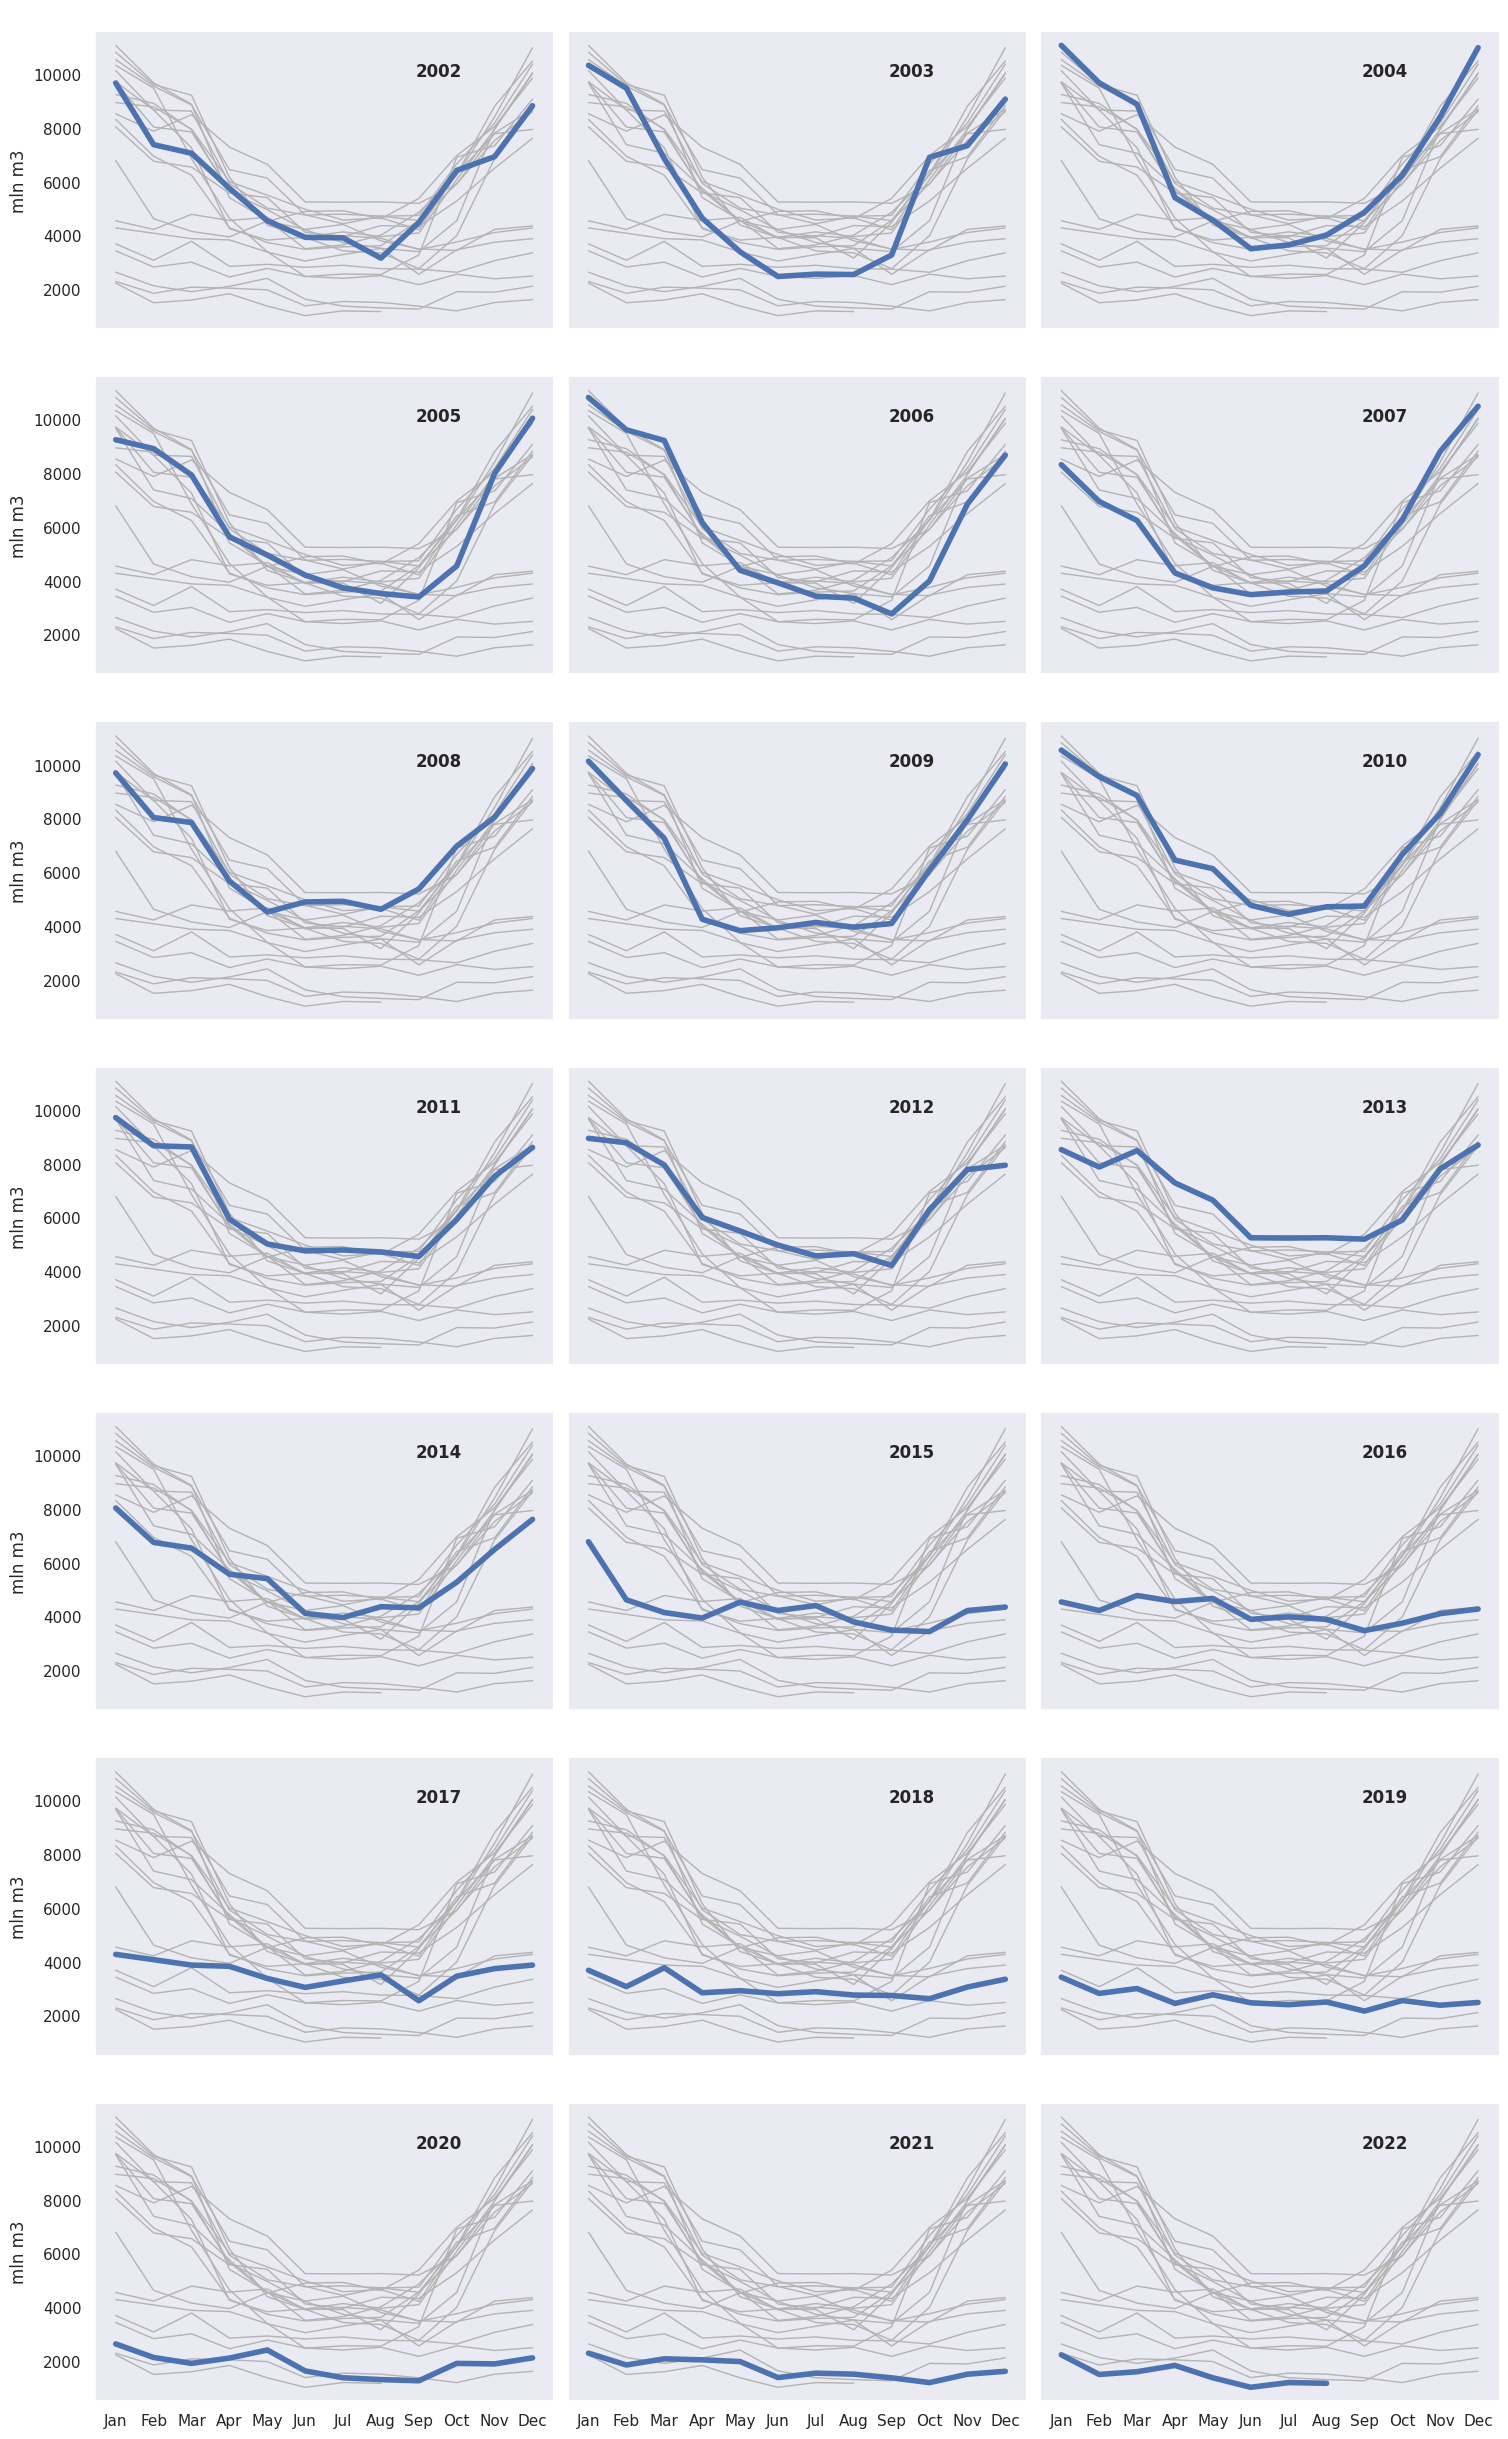

In [11]:
# Natural gas production in the Netherlands

# from the data dictionary retrieve the unit for this column
gas_volume_units = data_dictionary["IndigenousProduction_2"]["Unit"]

# Natural gas production by year (blue line)
g = sns.relplot(
    data=df,
    x="MonthLabel",
    y="IndigenousProduction_2",
    col="Year",
    kind="line",
    linewidth=4,
    zorder=5,
    col_wrap=3,
    height=3,
    aspect=2.1,
    legend=True,
)

# Iterate over each subplot to customize further (grey line)
for year, ax in g.axes_dict.items():
    ax.text(0.7, 0.85, year, transform=ax.transAxes, fontweight="bold")
    sns.lineplot(
        data=df,
        x="MonthLabel",
        y="IndigenousProduction_2",
        units="Year",
        estimator=None,
        color=".7",
        linewidth=1,
        ax=ax,
    )

# layout
g.set_titles(" ")
g.set_axis_labels("", gas_volume_units)
plt.gcf().set_size_inches(15, 25)
plt.show()

The next plot is to show to relation between how much gas is produced in the Netherlands and how much we consumed each year! For this, and many of the next plots, we used the Pandas DataFrame [melt](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html) function to reformat the data from a wide to a long format, also known as unpivot. We limit this to the columns **"production"** and **"consumption"**, which will be combined into a column called **"variable"**. By selecting the **"Year"** column as our identifier variable we loose the information about the month and get up to 12 values per year for gas production and/or consumption. Seaborn with use this information to show the bandwidth (high/low) in the plots.

In the layout we added a line to make sure the plot shows a y-axis from 0-max. If you would comment out this line it will use a dynamic range based on the data, and thus not show 0

```
plt.ylim(0, production_consumption_df["value"].max())
```

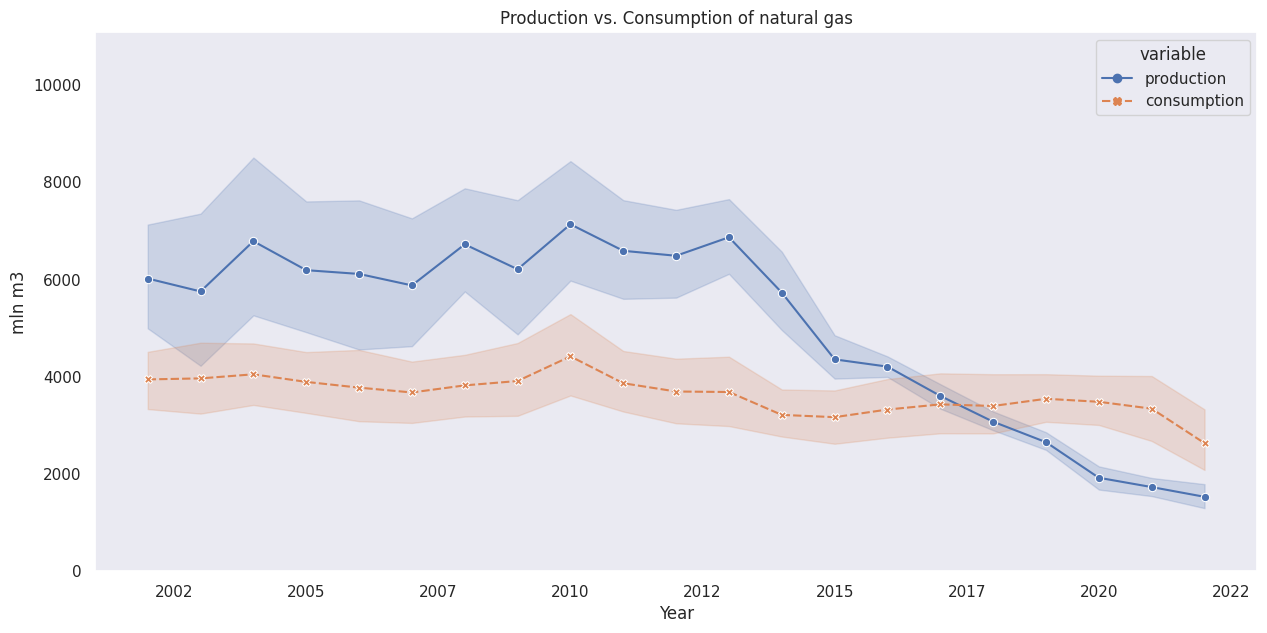

In [12]:
##############################################################################
# production / consumption
production_consumption_df = pd.melt(  # set data
    df, id_vars=["Year"], value_vars=["production", "consumption"]
)

sns.lineplot(  # plot
    x="Year",
    y="value",
    hue="variable",
    style="variable",
    markers=True,
    data=production_consumption_df,
).xaxis.set_major_formatter( # force year labels to integers
    FuncFormatter(lambda x, _: int(x))
)

# layout
plt.ylim(0, production_consumption_df["value"].max())
plt.ylabel(gas_volume_units)
plt.title("Production vs. Consumption of natural gas")
plt.gcf().set_size_inches(15, 7)
plt.show()

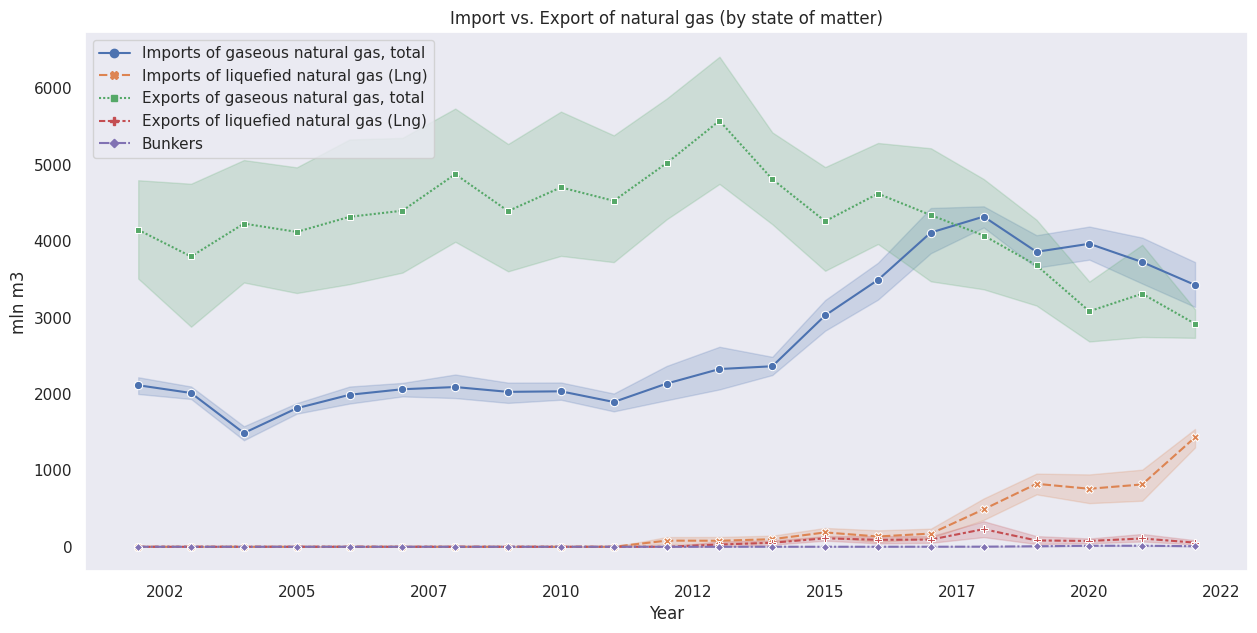

**Imports of gaseous natural gas, total:** Imports of gaseous natural gas through cross border pipelines.

**Imports of liquefied natural gas (Lng):** Imports of liquefied natural gas (Lng).
The gas is liquefied through cooling till about minus 160 degrees Celsius. This makes transport in ships over long distances possible.

**Exports of gaseous natural gas, total:** Exports of gaseous natural gas through cross border pipelines.

**Exports of liquefied natural gas (Lng):** Exports of liquefied natural gas (Lng).
The gas is liquefied through cooling till about minus 160 degrees Celsius. This makes transport in ships over long distances possible.

**Bunkers:** Delivery of fuels for international shipping and aviation, i.e. ships and aircraft departing from Dutch (air)ports and arriving in foreign (air)ports. Bunkers are considered as a form of export and are not included in energy available for consumption in the Netherlands.

In [13]:
##############################################################################
# import vs export by state

import_export_state_df = pd.melt(  # set data
    df,
    id_vars=["Year"],
    value_vars=[
        "ImportsOfGaseousNaturalGasTotal_4",
        "ImportsOfLiquefiedNaturalGasLng_10",
        "ExportsOfGaseousNaturalGasTotal_11",
        "ExportsOfLiquefiedNaturalGasLng_17",
        "Bunkers_18"
    ],
)

# Gas import/export
ie = sns.lineplot(  # plot
    x="Year",
    y="value",
    hue="variable",
    style="variable",
    markers=True,
    data=import_export_state_df,
)

ie.xaxis.set_major_formatter( # force year labels to integers
    FuncFormatter(lambda x, _: int(x))
)

# labels
handles, labels = ie.get_legend_handles_labels()
ie.legend(
    handles,
    [data_dictionary[l]["Title"] for l in labels],
    loc="upper left"
)

# layout
plt.ylabel(gas_volume_units)
plt.title("Import vs. Export of natural gas (by state of matter)")
plt.gcf().set_size_inches(15, 7)
plt.show()

for l in labels:
    display(Markdown(f"**{data_dictionary[l]['Title']}:** {data_dictionary[l]['Description']}"))


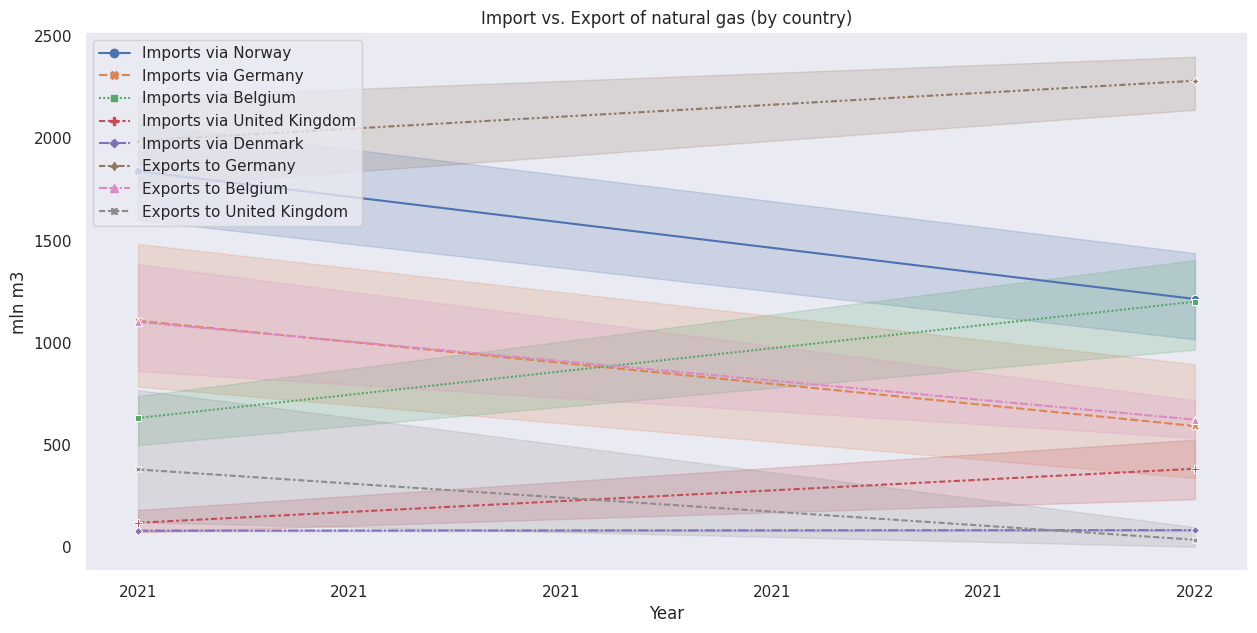

**Imports via Norway:** Imports of gaseous natural gas through cross border pipelines. Norwegian gas passes Germany and passes  the border by Emden

**Imports via Germany:** Imports of gaseous natural gas through cross border pipelines of Germany except for the cross border by Emden.

**Imports via Belgium:** Imports of gaseous natural gas through cross border pipelines from Belgium.

**Imports via United Kingdom:** Imports of gaseous natural gas through cross border pipelines from the United Kingdom.  

**Imports via Denmark:** Imports of gaseous natural gas through cross border pipelines from Denmark.

**Exports to Germany:** Exports of gaseous natural gas through cross border pipelines to Germany, except cross border pipeline bij Emden.

**Exports to Belgium:** Exports of gaseous natural gas through cross border pipelines to Belgium.

**Exports to United Kingdom:** Exports of gaseous natural gas through cross borderBBL- pipelines to United Kingdom.

In [14]:

##############################################################################
# import vs export by state

import_export_country_df = pd.melt(  # set data
    df,
    id_vars=["Year"],
    value_vars=[
        "ImportsViaNorway_5",
        "ImportsViaGermany_6",
        "ImportsViaBelgium_7",
        "ImportsViaUnitedKingdom_8",
        "ImportsViaDenmark_9",
        "ExportsToNorway_12",
        "ExportsToGermany_13",
        "ExportsToBelgium_14",
        "ExportsToUnitedKingdom_15",
        "ExportsToDenmark_16"
    ],
)

# Gas import/export
ie = sns.lineplot(  # plot
    x="Year",
    y="value",
    hue="variable",
    style="variable",
    markers=True,
    data=import_export_country_df.query("value > 0")
)

ie.xaxis.set_major_formatter( # force year labels to integers
    FuncFormatter(lambda x, _: int(x))
)

# labels
handles, labels = ie.get_legend_handles_labels()
ie.legend(
    handles,
    [data_dictionary[l]["Title"] for l in labels],
    loc="upper left"
)

# layout
plt.ylabel(gas_volume_units)
plt.title("Import vs. Export of natural gas (by country)")
plt.gcf().set_size_inches(15, 7)
plt.show()

for l in labels:
    display(Markdown(f"**{data_dictionary[l]['Title']}:** {data_dictionary[l]['Description']}"))

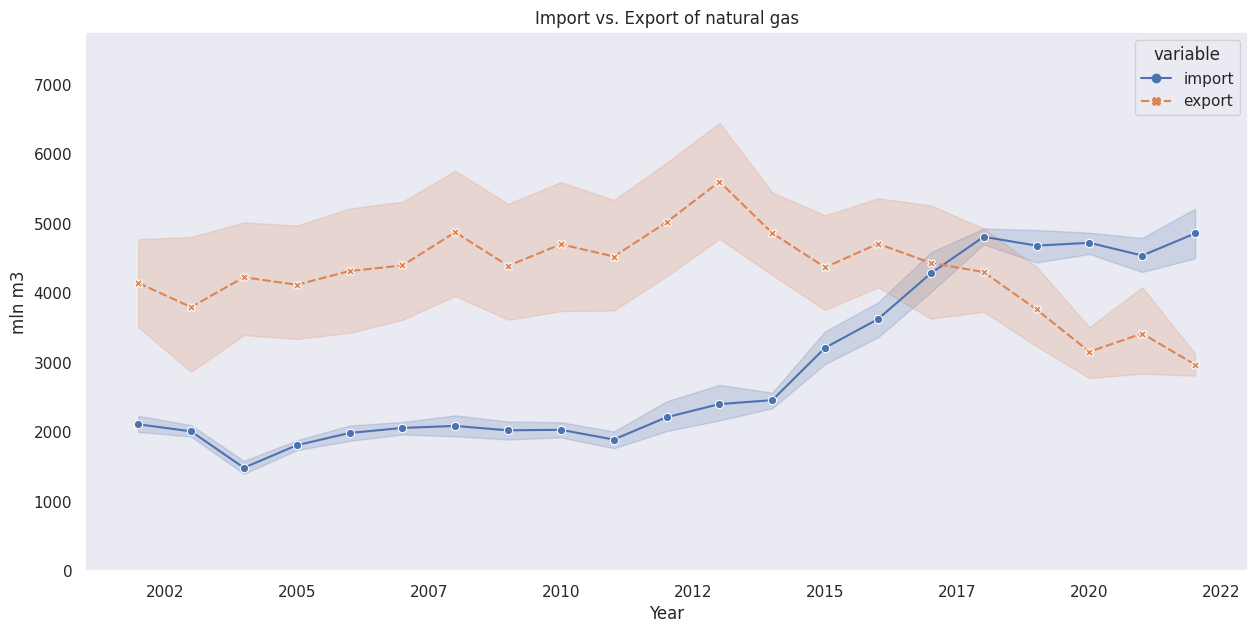

In [15]:
##############################################################################
# import / export
import_export_df = pd.melt(  # set data
    df, id_vars=["Year"], value_vars=["import", "export"]
)

sns.lineplot(  # plot
    x="Year",
    y="value",
    hue="variable",
    style="variable",
    markers=True,
    data=import_export_df,
).xaxis.set_major_formatter( # force year labels to integers
    FuncFormatter(lambda x, _: int(x))
)

# layout
plt.ylim(0, import_export_df["value"].max())
plt.ylabel(gas_volume_units)
plt.title("Import vs. Export of natural gas")
plt.gcf().set_size_inches(15, 7)
plt.show()

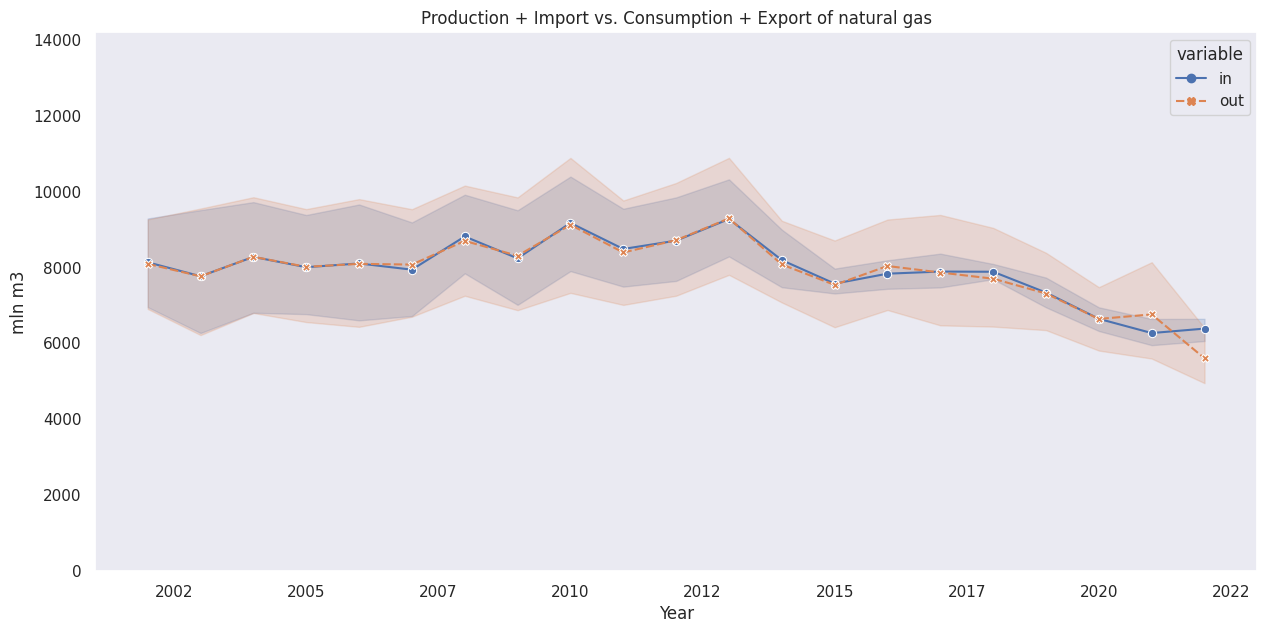

In [16]:
##############################################################################
# in / out
in_out_df = pd.melt( # set data
    df, id_vars=["Year"], value_vars=["in", "out"]
)

sns.lineplot(
    x="Year",
    y="value",
    hue="variable",
    style="variable",
    markers=True,
    data=in_out_df
).xaxis.set_major_formatter( # force year labels to integers
    FuncFormatter(lambda x, _: int(x))
)

# layout
plt.ylim(0, in_out_df["value"].max())
plt.ylabel(gas_volume_units)
plt.title("Production + Import vs. Consumption + Export of natural gas")
plt.gcf().set_size_inches(15, 7)
plt.show()

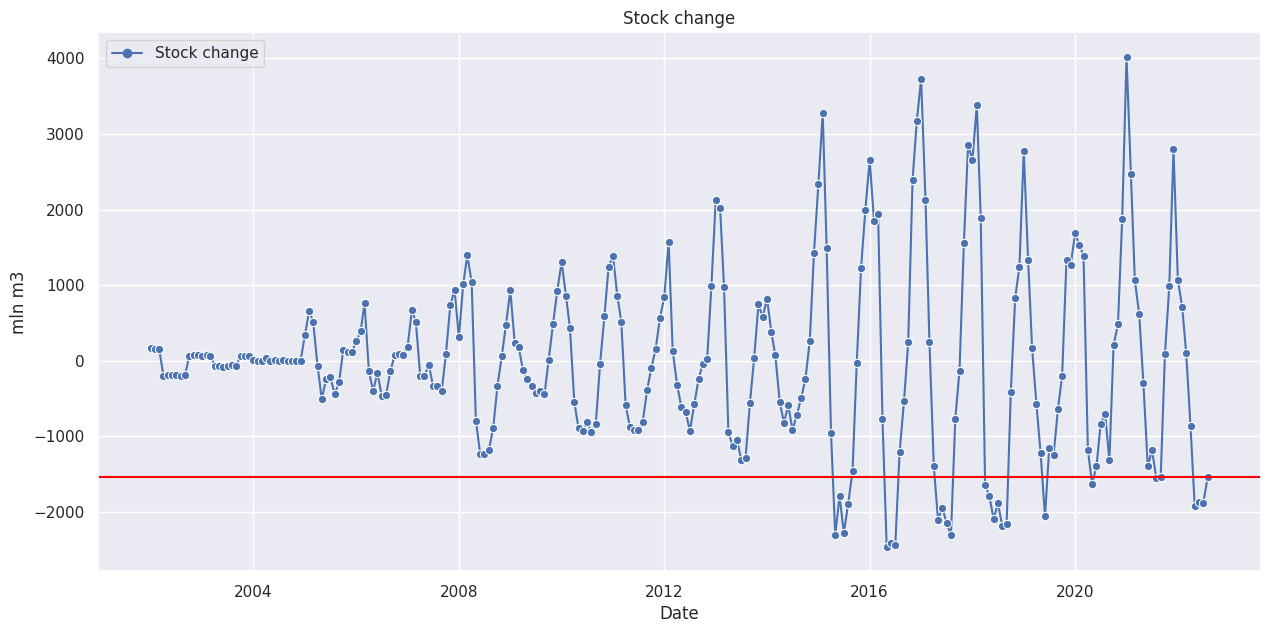

**Stock change**

Stock change of natural gas in underground storages and stock changes of liquefied natural gas (Lng). Includes also small changes in the emergency supply of natural gas and in the natural gas pipelines. During extremely cold weather the emergency supply is used to keep the natural gas supply at the normal level. During hot weather the emergency supply is supplemented again. The change of stock is calculated as the opening stock minus the closing stock, in accordance with international energy statistics guidelines. A positive figure means that the stock has decreased, and the supply of natural gas has thus increased. A negative figure means the opposite: an increase in stock and decrease in consumption.


In [17]:
##############################################################################
# stock
stock_df = pd.melt(  # set data
    df.query("Year >= 2000"),
    id_vars=["Date"],
    value_vars=[
        "StockChange_19"
    ],
)

# Stock in the Netherlands
stock = sns.lineplot(  # plot
    x="Date",
    y="value",
    hue="variable",
    style="variable",
    markers=True,
    data=stock_df,
)

# add line of current value
current_stock = stock_df.iloc[-1]['value']
stock.axhline(current_stock, color="red")

# labels
handles, labels = stock.get_legend_handles_labels()
stock.legend(
    handles,
    [data_dictionary[l]["Title"] for l in labels],
    loc="upper left"
)

# layout
plt.ylabel(gas_volume_units)
plt.grid(True)
plt.title("Stock change")
plt.gcf().set_size_inches(15, 7)
plt.show()

for l in labels:
    display(Markdown(f"**{data_dictionary[l]['Title']}**"))
    display(Markdown(f"{data_dictionary[l]['Description']}"))
